<a href="https://colab.research.google.com/github/santhosharun99/stock-price-prediction/blob/main/stock%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
import matplotlib.pyplot as plt
import json
from tensorflow.keras.callbacks import EarlyStopping

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(2)



In [6]:
# Load the dataset from CSV files
stocks_data = pd.read_csv('sp500_stocks.csv')
index_data = pd.read_csv('sp500_index.csv')
companies_data = pd.read_csv('sp500_companies.csv')

# Assuming 'Date' is a column in the dataset, set it as the index
stocks_data.set_index('Date', inplace=True)
index_data.set_index('Date', inplace=True)

# Extract the relevant data for S&P500 from the index dataset
cl = index_data['S&P500']

# Preprocess the data using MinMaxScaler
cv = cl.values.reshape(-1, 1)
scl = MinMaxScaler()
cv = scl.fit_transform(cv)

# Function to process the data into sequences for LSTM
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb):
        X.append(data[i:(i + lb), 0])
        Y.append(data[i + lb, 0])
    return np.array(X), np.array(Y)



In [7]:
# Prepare the data for training and testing
X, y = processData(cv, 14)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into train and test sets
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



In [8]:
# Define the Bidirectional LSTM model with additional layers and optimized hyperparameters
bidirectional_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2]))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model with metrics for evaluation
bidirectional_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse',
                                 metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(),
                                          tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

# Implement early stopping during training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Train the model and save the training history
history = bidirectional_lstm_model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),
                                       callbacks=[early_stopping], shuffle=False, verbose=1)
bidirectional_lstm_model.save("bidirectional_lstm_model.h5")
with open("bidirectional_lstm_model_history.json", "w") as f:
    json.dump(history.history, f)



Epoch 1/200
63/63 [==============================] - 13s 72ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0332 - mean_absolute_percentage_error: 17.3370 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0452 - val_root_mean_squared_error: 0.0602 - val_mean_absolute_percentage_error: 6.0539
Epoch 2/200
63/63 [==============================] - 2s 30ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0431 - root_mean_squared_error: 0.0585 - mean_absolute_percentage_error: 45.7348 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0778 - val_root_mean_squared_error: 0.0880 - val_mean_absolute_percentage_error: 11.9665
Epoch 3/200
63/63 [==============================] - 2s 29ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0351 - root_mean_squared_error: 0.0585 - mean_absolute_percentage_error: 56.2046 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Evaluate the model using test data
evaluation_metrics = bidirectional_lstm_model.evaluate(X_test, y_test, verbose=0)
print("Evaluation Metrics:")
print(f"MSE: {evaluation_metrics[1]}")
print(f"MAE: {evaluation_metrics[2]}")
print(f"RMSE: {evaluation_metrics[3]}")
print(f"MAPE: {evaluation_metrics[4]}")

# Make predictions and inverse transform to get actual values
y_pred = bidirectional_lstm_model.predict(X_test)
y_actual = scl.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
y_pred = scl.inverse_transform(y_pred).reshape(-1)




Evaluation Metrics:
MSE: 0.0010702927829697728
MAE: 0.026573020964860916
RMSE: 0.0327153280377388
MAPE: 3.766730785369873
16/16 [==============================] - 4s 24ms/step



Actual vs Predicted Values:
Actual: 4500.21 | Predicted: 4506.95
Actual: 4488.28 | Predicted: 4507.11
Actual: 4412.53 | Predicted: 4506.14
Actual: 4397.45 | Predicted: 4497.46
Actual: 4446.59 | Predicted: 4489.33
Actual: 4392.59 | Predicted: 4482.62
Actual: 4391.69 | Predicted: 4471.10
Actual: 4462.21 | Predicted: 4458.80
Actual: 4459.45 | Predicted: 4450.69
Actual: 4393.66 | Predicted: 4444.11


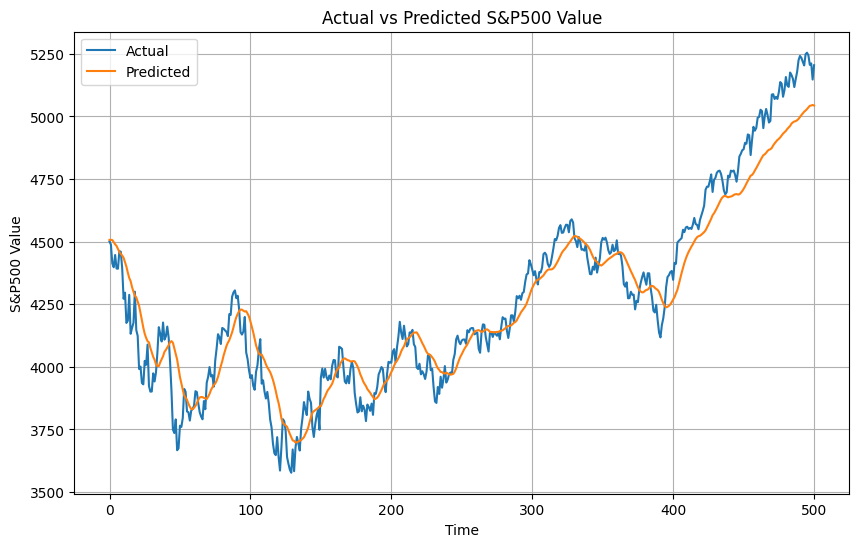

In [10]:
# Print actual vs predicted values
print("\nActual vs Predicted Values:")
for i in range(10):
    print(f"Actual: {y_actual[i]:.2f} | Predicted: {y_pred[i]:.2f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('S&P500 Value')
plt.title('Actual vs Predicted S&P500 Value')
plt.legend()
plt.grid(True)
plt.show()